# Analysis notebook

In [1]:
from mdtraj import density
import mdtraj as mdt
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("seaborn")
plt.style.use("tex")

figdir = "figures/"

In [2]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [3]:
# Active residues
act_chain_a = [92,93,95,98,171,172,173,180,181,182,221,226,227,228,310, "EFZ"]
act_chain_b = [648-520+1, "EFZ"]


In [4]:
gofr_chain_a_efz = [] 
for res in act_chain_a:
    gofr_chain_a_efz.append(np.genfromtxt(f"src/res/chain_a_md/gofr_{res}.dat"))

gofr_chain_a_efz = np.array(gofr_chain_a_efz) 

gofr_chain_b_efz = [] 
for res in act_chain_b:
    gofr_chain_b_efz.append(np.genfromtxt(f"src/res/chain_b_md/gofr_{res}.dat"))

gofr_chain_b_efz = np.array(gofr_chain_b_efz) 


In [10]:
chain_a_traj = mdt.load("src/res/chain_a_efz_solv_box_md.nc",top="src/res/chain_a_efz_solv_box.prmtop")
chain_b_traj = mdt.load("src/res/chain_b_efz_solv_box_md.nc",top="src/res/chain_b_efz_solv_box.prmtop")

prot_a = chain_a_traj.atom_slice(chain_a_traj.topology.select("protein"))
prot_b = chain_b_traj.atom_slice(chain_b_traj.topology.select("protein"))

efz_a = chain_a_traj.atom_slice(chain_a_traj.topology.select("resname EFZ"))
efz_b = chain_b_traj.atom_slice(chain_b_traj.topology.select("resname EFZ"))

avg_dens_a = density(chain_a_traj.atom_slice(chain_a_traj.topology.select("resname HOH"))).mean()
avg_dens_b = density(chain_b_traj.atom_slice(chain_b_traj.topology.select("resname HOH"))).mean()

ValueError: The topology and the trajectory files might not contain the same atoms
The input topology must contain all atoms even if you want to select a subset of them with atom_indices

## Radial distribution function and coordination number

In [21]:
cnum_chain_a_efz = gofr_chain_a_efz.copy()
cnum_chain_a_efz[:,:,1] = 4*np.pi*avg_dens_a*cnum_chain_a_efz[:,:,1]*cnum_chain_a_efz[:,:,0]**2

temp = cumtrapz(gofr_chain_a_efz[:,:,1],gofr_chain_a_efz[:,:,0])
cnum_chain_a_efz = cnum_chain_a_efz[:,1:,:] - cnum_chain_a_efz[:,:1,:]
cnum_chain_a_efz[:,:,1] = temp

In [22]:
cnum_chain_b_efz = gofr_chain_b_efz.copy()
cnum_chain_b_efz[:,:,1] = 4*np.pi*avg_dens_b*cnum_chain_b_efz[:,:,1]*cnum_chain_b_efz[:,:,0]**2

temp = cumtrapz(gofr_chain_b_efz[:,:,1],gofr_chain_b_efz[:,:,0])
cnum_chain_b_efz = cnum_chain_b_efz[:,1:,:] - cnum_chain_b_efz[:,:1,:]
cnum_chain_b_efz[:,:,1] = temp

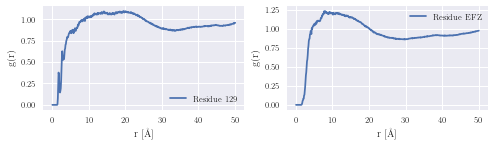

In [ ]:
fig, axes = plt.subplots(1,2, figsize=set_size(500,subplots=(1,2)))
axes = np.array(axes)
plt.xlabel("r")
plt.ylabel("g(r)")
for i, (ax,res,res2) in enumerate(zip(axes.flatten(),gofr_chain_b_efz,cnum_chain_b_efz)):
    ax.plot(res[:,0], res[:,1], label = f"Residue {act_chain_b[i]}" )
    ax2 = ax.twinx()
    ax2.plot(res2[:,0], res2[:,1], alpha=0.7)

    ax.set_xlabel(r"r [\AA]")
    ax.set_ylabel("g(r)")
    ax2.set_ylabel("K(r)")

    ax.legend()

plt.tight_layout()
plt.savefig(figdir+"b_chain_act.pdf")

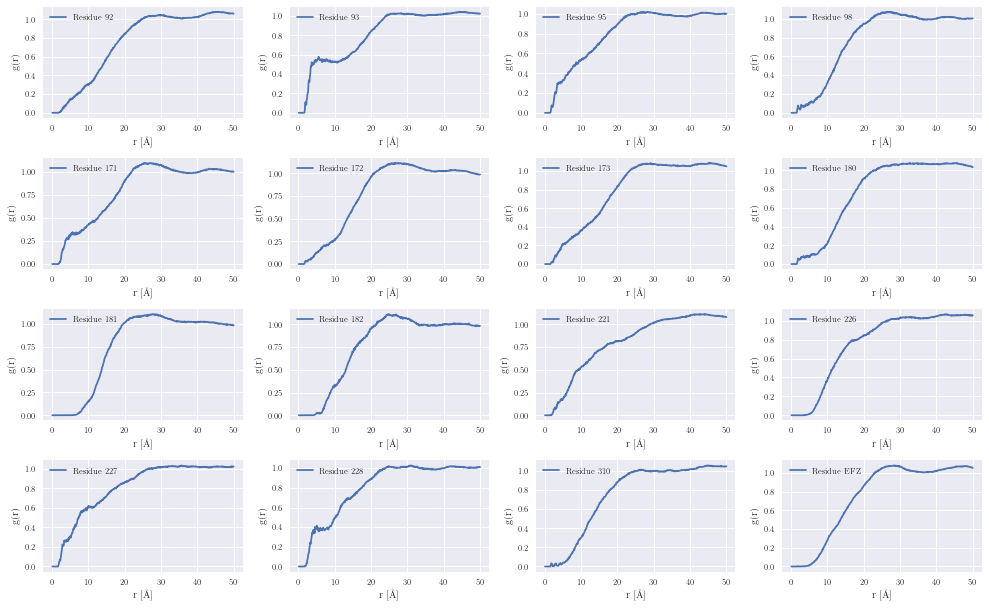

In [ ]:
fig, axes = plt.subplots(4,4, figsize=set_size(1000,subplots=(4,4)))
plt.xlabel("r")
plt.ylabel("g(r)")
for i, (ax,res,res2) in enumerate(zip(axes.flatten(),gofr_chain_a_efz,cnum_chain_a_efz)):
    ax.plot(res[:,0], res[:,1], label = f"Residue {act_chain_a[i]}" )
    ax2 = ax.twinx()
    ax2.plot(res2[:,0], res2[:,1], alpha=0.7)

    ax.set_xlabel(r"r [\AA]")
    ax.set_ylabel("g(r)")
    ax2.set_ylabel("K(r)")

    ax.legend()

plt.tight_layout()
plt.savefig(figdir+"a_chain_act.pdf")

## RMSD

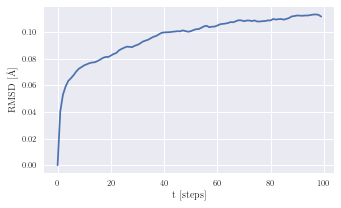

In [ ]:
fig, axes = plt.subplots(1,2, figsize=set_size(700,subplots=(1,1)))
axes = np.array(axes)
plt.xlabel("t [steps]")
plt.ylabel(r"RMSD [\AA]")

axes[0].plot(mdt.rmsd(prot_a,prot_a))
axes[1].plot(mdt.rmsd(prot_b,prot_b))

plt.tight_layout()
plt.savefig(figdir+"rmsd.pdf")

## RMSF

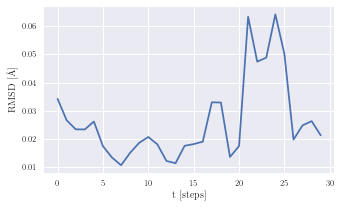

In [9]:
fig, axes = plt.subplots(1,2, figsize=set_size(350,subplots=(1,1)))
axes = np.array(axes)
plt.xlabel("t [steps]")
plt.ylabel(r"RMSD [\AA]")

axes[0].plot(mdt.rmsf(efz_a,efz_a))
axes[1].plot(mdt.rmsd(efz_b,efz_b))

plt.tight_layout()
plt.savefig(figdir+"rmsd_efz.pdf")
